## The Area API endpoint

This is an example of using the area API endpoint. It can be used to get level2 data for a certain area of the Earth during a certain time period.

See the [api docs](http://odin.rss.chalmers.se/apidocs/index.html?url=/rest_api/v4/spec#!/level2/get_rest_api_version_level2_project_area) for specification of inputs and outputs for this endpoint.

We will be looking at the O3 product in this demo:

In [3]:
product = "O3 / 501 GHz / 20 to 50 km"

This demo will generate a heatmap of average VMR per month and latitude range. The code is written in python and fetches data from the area API endpoint.

The first function calculates the average VMR for a certain latitude range and time range.

In [4]:
import requests
def get_latitude_average(product, start_lat, end_lat, start_time, end_time, verbose=True):
    """Calculate average vmr for a certain product and in a certain time
    and latitude range
    """
    url = 'http://odin.rss.chalmers.se/rest_api/v4/level2/QSMRVDS/area'
    params = {
        'product' : product,
        'start_time': start_time,
        'end_time': end_time,
        'min_lat': start_lat,
        'max_lat': end_lat,
        'min_lon': 0,
        'max_lon': 360,
        'min_altitude': 0,
        'max_altitude': 150000}
    r = requests.get(url, params)

    if r.status_code != 200:
        print r.status_code
        print r.text
        raise
    data = r.json()
    if not data['Info']['Nr']:
        # No matching scans
        return 0.0

    nr_scans = len(set([element['ScanID'] for element in data['Info']['Results']]))
    if verbose:
        print start_time, 'Nr scans:', nr_scans
    sum_vmr = sum([element['VMR'] for element in data['Info']['Results']])
    return sum_vmr/nr_scans

Get the average VMR between 55 N to 70 N in november 2010:

In [5]:
get_latitude_average(product, 55, 70, '2010-11-01', '2010-12-01')

2010-11-01 Nr scans: 17


7.090816265593464e-05

The next function loops over all months between 2005 to 2015 and calculates the average VMR for each month for a certain latitude range.

In [12]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def get_latitude_average_over_time(product, start_lat, end_lat, verbose=False):
    """Calculate average vmr for each month for a certain product and in a
    certain latitude range
    """
    start_time = datetime(2005, 1, 1)
    end_time = datetime(2015, 1, 1)

    average_vmr = []
    time = []

    current = start_time
    while current < end_time:
        end = current + relativedelta(months=1)
        average_vmr.append(get_latitude_average(product, start_lat, end_lat, current, end, verbose=verbose))
        time.append(current)
        current = end
    
    return average_vmr, time

The last function loops over the latitude ranges and produces a matrix of average VMR.

In [13]:
def get_lat_average_over_time_and_lat(product, lat_step=15, verbose=False):
    """Calculate average vmr for each month and latitude range"""
    data = []
    lat = []
    for start_lat in range(-90, 90, lat_step):
        av_vmr, time = get_latitude_average_over_time(product, start_lat, start_lat+lat_step, verbose=verbose)
        data.append(av_vmr)
        lat.append(start_lat)
    return data, lat, time

In [14]:
average_vmr, latitudes, months = get_lat_average_over_time_and_lat(product)

And finally we make a heatmap plot of the data:

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def heatmap(data, lat, time):
    plt.rcParams["figure.figsize"] = (16,10)

    fig, ax = plt.subplots()
    ax.pcolor(data)

    # Move ticks to middle of each cell
    ax.set_yticks(np.arange(len(lat)) + 0.5, minor=True)
    ax.set_yticks(np.arange(0), minor=False)
    ax.set_xticks(np.arange(0, len(time), 12), minor=False)

    # Set labels
    ax.set_xticklabels([t.strftime('%y') for t in time if t.month == 1], minor=False)
    ax.set_yticklabels(['%d to %d' % (l, l+15) for l in lat], minor=True)

    ax.grid(which='major', linestyle='-', color='k')                                                

    # Turn off all the ticks
    ax = plt.gca()
    
    plt.ylabel('Latitude')
    plt.xlabel('Year')

    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_minor_ticks():
        t.tick1On = False
        t.tick2On = False

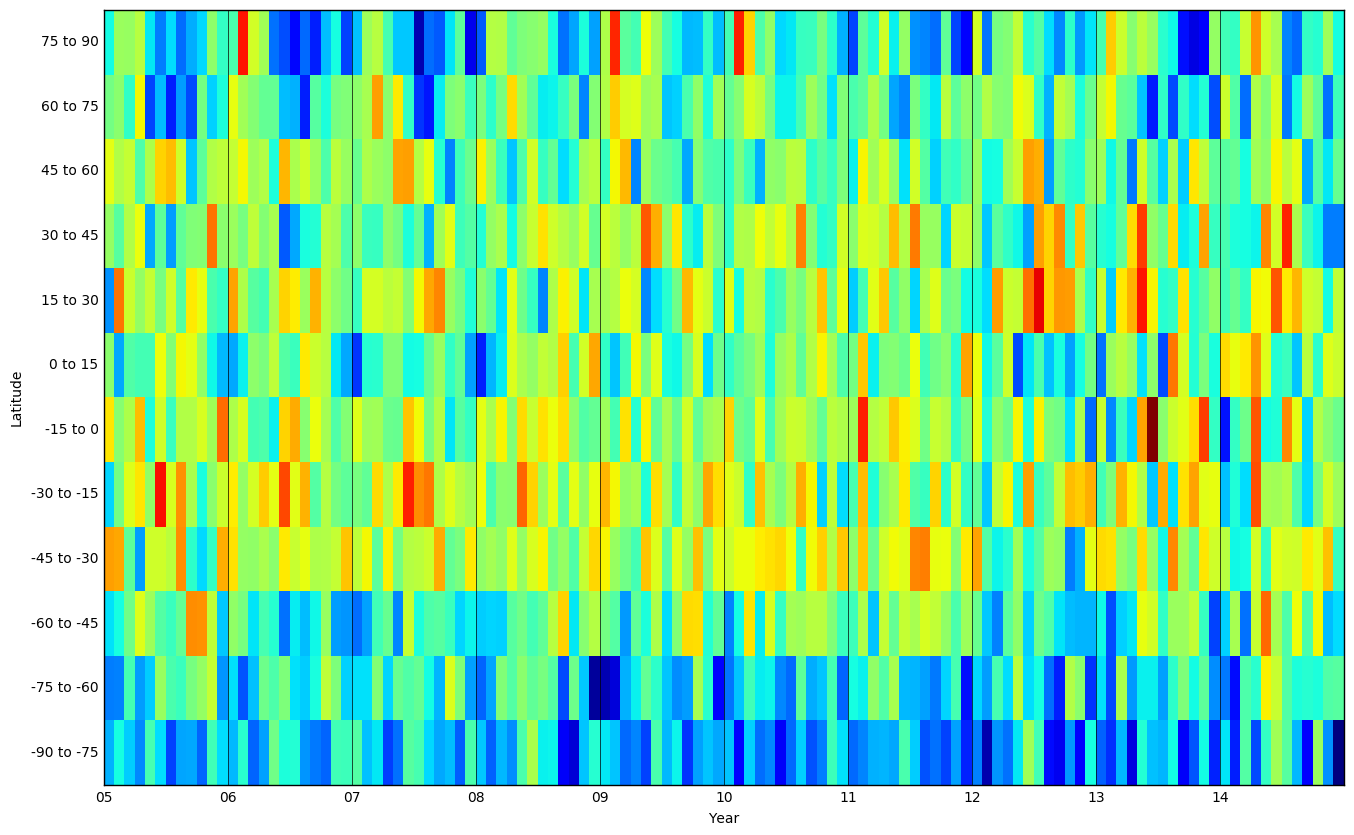

In [16]:
heatmap(average_vmr, latitudes, months)